<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/Main_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
# GPU Processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

Using TensorFlow backend.


Found GPU at:/device:GPU:0


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train = X_train[:30000,:,:]
Y_train = Y_train[:30000]
X_test  = X_test[:5000,:,:]
Y_test  = Y_test[:5000]

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((30000, 28, 28), (30000,), (5000, 28, 28), (5000,))

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5

X_train.shape

(30000, 28, 28, 1)

In [0]:
def build_generator(input_dim):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=input_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_discriminator(input_shape):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


In [7]:
generator = Sequential([
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
    ])

# generator = build_generator(input_dim=100)


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation=<keras.lay..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="tanh", padding="same")`
  if __name__ == '__main__':


In [8]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [9]:
discriminator = Sequential([
        Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

# discriminator = build_discriminator(input_shape=(28,28,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., activation=<keras.lay..., strides=(2, 2), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.


In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [13]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [14]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [0]:
def save_imgs(epoch, save_folder='.'):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_folder + "/mnist_%d.png" % epoch)
    plt.show()
    plt.close()
    
def show_imgs(epoch, predictions, save_folder='.'):
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(predictions[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_folder + "/mnist_%d.png" % epoch)
    plt.show()
    plt.close()    
    
def plot_output(num=10):
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)
    
    show_imgs(10, preds)
#     plt.figure(figsize=(10,10))
#     for i in range(preds.shape[0]):
#         plt.subplot(num, num, i+1)
#         plt.imshow(preds[i, :, :, 0], cmap='gray')
#         plt.axis('off')
    
#     # tight_layout minimizes the overlap between 2 sub-plots
#     plt.tight_layout()  
#     plt.show()

In [0]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)
        if epoch % 100 == 0:
            print("Epoch:", epoch)
            plot_output(5)
            

100%|██████████| 937/937 [00:33<00:00, 33.42it/s]


Epoch: 1000


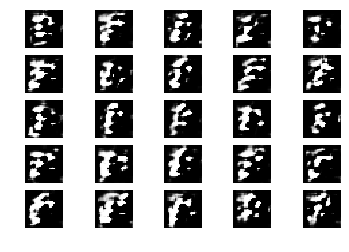

100%|██████████| 937/937 [00:28<00:00, 33.31it/s]


Epoch: 1000


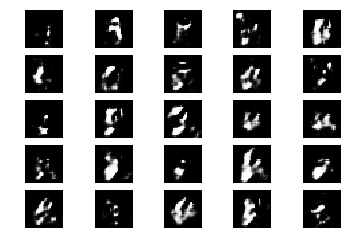

100%|██████████| 937/937 [00:28<00:00, 33.31it/s]


Epoch: 1000


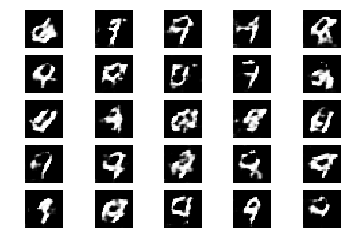

100%|██████████| 937/937 [00:28<00:00, 33.32it/s]


Epoch: 1000


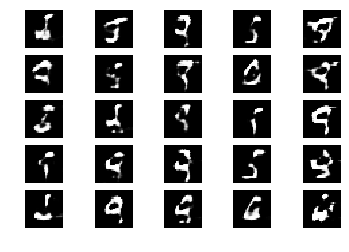

100%|██████████| 937/937 [00:28<00:00, 33.38it/s]


Epoch: 1000


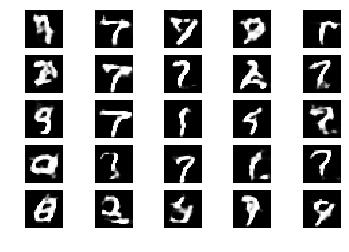

100%|██████████| 937/937 [00:28<00:00, 33.37it/s]


Epoch: 1000


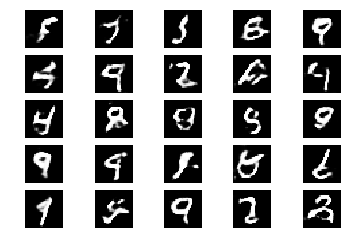

100%|██████████| 937/937 [00:28<00:00, 33.40it/s]


Epoch: 1000


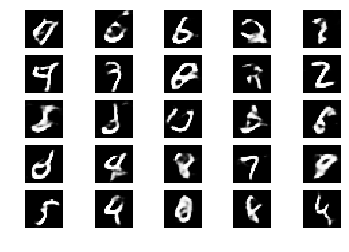

100%|██████████| 937/937 [00:28<00:00, 33.32it/s]


Epoch: 1000


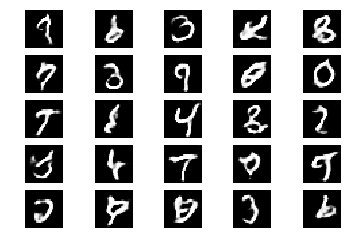

 16%|█▌        | 148/937 [00:04<00:23, 33.38it/s]

In [0]:
train(epoch=1000, batch_size=32)

In [0]:
generator.save_weights('gen_20_scaled_images.h5')
discriminator.save_weights('dis_20_scaled_images.h5')

In [0]:
train(20, 128)

In [0]:
generator.save_weights('gen_40_scaled_images.h5')
discriminator.save_weights('dis_40_scaled_images.h5')

In [0]:
generator.load_weights('gen_40_scaled_images.h5')
discriminator.load_weights('dis_40_scaled_images.h5')

In [0]:
plot_output()